In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time as t
from scipy import interpolate
from astropy.io import ascii
import h5py
from matplotlib import cm
import astropy.units as u
from astropy.cosmology import Planck15 as Planck
import os
os.environ['MKL_NUM_THREADS'] = '1' # this command prevents Python from multithreading 
                                    #(useful especiallfy for Demoblack machine!)
import time
import random
from scipy.interpolate import interp1d
import corner
from tqdm import tqdm
import matplotlib as mpl
from matplotlib.ticker import LogFormatter

In [2]:
cosmo_sim = 'EAGLE'

snapshot = '6' # 28 corresponds to local Universe
gal_mass_min = '1E07' # I should go down to 10^8 Msun but there might be up to 10^5 galaxies
gal_mass_max = '1E12'
central_galaxy = '0' # 0 correspond to only central galaxies
sfr_min = '0.0001' # check again this extremes 
sfr_max = '10000' # check again this extreme
N_Eagle = 'all'

z_Eagle = np.loadtxt('z_mid_'+cosmo_sim +'.txt', usecols = 0)[28-int(snapshot):]
print(z_Eagle)

hdf5 = 'Yes'

[ 5.97116232  7.04956627  8.07461643  8.98787498  9.99303341 15.13231087
 20.00002098]


In [3]:
destination = cosmo_sim+'_catalogs/merger_trees/'

if hdf5 == 'Yes':
    catalogue_filename = destination+'/'+cosmo_sim+'-MergerTrees_Ms'+gal_mass_min+'-'+gal_mass_max+\
                   '_SFR'+sfr_min+'-'+sfr_max+'_N'+N_Eagle+'_'+snapshot+'.hdf5'
    # let's read the hdf5 catalogue and put info in a not nested database
    data = h5py.File(catalogue_filename, 'r')
    # number of total galaxies in the database
    N_gal = len(data.keys())
    print('Number of galaxy at redshift zero = ', N_gal)
    
    len_dset = np.zeros(N_gal+1, dtype = int)
    tot_len_dset = 0
    i = 1
    #with alive_bar(len(data.keys())) as bar:
    print('Counting the number of progenitor per each galaxy...')
    for group in tqdm(data.keys()) :
        #print(len(data[group]['MassType_Star']), '=', int(data[group]['MassType_Star'].shape[0]))
        len_dset[i] = len_dset[i-1] + data[group]['MassType_Star'].size
        tot_len_dset = tot_len_dset + data[group]['MassType_Star'].size
        i = i + 1
    print('total number of galaxies per each galaxy at any redshift = ', len_dset)
    print('total number of galaxies at any redshift = ', tot_len_dset, len_dset[N_gal])
    
    #galaxy_data_all = np.zeros((4,tot_len_dset))
    galaxy_data_progenitor =  np.zeros((4,tot_len_dset))
    galaxy_data_remnant =  np.zeros((4,N_gal))
    i = 1
    print('Saving the properties of each progenitor galaxy')
    for group_2 in tqdm(data.keys()) :
        len_dset_temp = data[group_2]['MassType_Star'].shape
        y = 0 
        for dset in ['MassType_Star', 'StarFormationRate','Redshift']:
            ds_data = data[group_2][dset] # returns HDF5 dataset object
            arr = np.array(data[group_2][dset]) 
            #galaxy_data_all[y, len_dset[i-1]:len_dset[i]] = arr
            galaxy_data_progenitor[y, len_dset[i-1]:len_dset[i]] = arr
            if arr.size != 1 :
                #print(arr.size)
                #print(arr)
                galaxy_data_remnant[y, i-1] = arr[0]
                
            elif arr.size == 1 :
                #print('no merger tree for ID = ', group)
                galaxy_data_remnant[y, i-1] = arr
                
            else:
                #print('no galaxy data for ID = ', group)
                galaxy_data_remnant[y, i-1] = 0
            y = y + 1
        #galaxy_data_all[y,len_dset[i-1]:len_dset[i]] = np.ones(len_dset[i]-len_dset[i-1], dtype = int)*i
        galaxy_data_progenitor[y,len_dset[i-1]:len_dset[i]] = np.ones(len_dset[i]-len_dset[i-1], dtype = int)*i
        galaxy_data_remnant[y, i-1] = i
        i = i + 1
            
        
print('Total number of galaxies = ',i-1)

N_totgal_tree = tot_len_dset

#EAGLE_gal_id = np.unique(galaxy_data_all[3,:])

EAGLE_gal_id = np.unique(galaxy_data_progenitor[3,:])

print(cosmo_sim+' IDs = \n', EAGLE_gal_id)


  0%|          | 0/50544 [00:00<?, ?it/s]

Number of galaxy at redshift zero =  50544
Counting the number of progenitor per each galaxy...


  0%|          | 34/50544 [00:00<02:28, 339.61it/s]

total number of galaxies per each galaxy at any redshift =  [     0     16     25 ... 740307 740312 740345]
total number of galaxies at any redshift =  740345 740345
Saving the properties of each progenitor galaxy


100%|██████████| 50544/50544 [01:31<00:00, 553.53it/s]

Total number of galaxies =  50544
EAGLE IDs = 
 [1.0000e+00 2.0000e+00 3.0000e+00 ... 5.0542e+04 5.0543e+04 5.0544e+04]


total number of progenitors =  740345


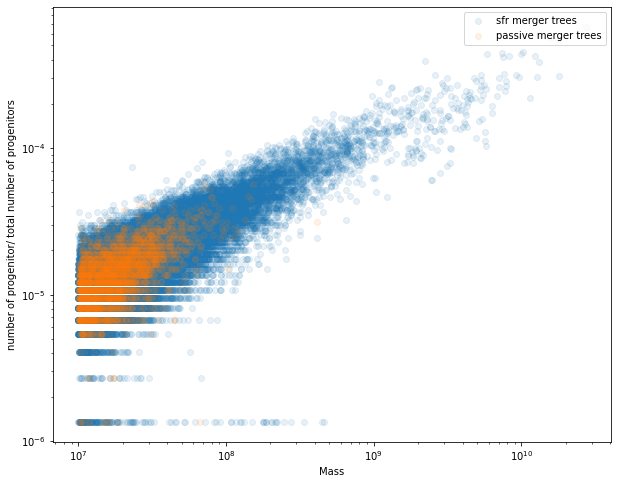

In [4]:
# number of progenitor galaxy as a function of the mass
plt.figure(figsize=(10,8))

num_prog = len_dset[1:len(len_dset)]-len_dset[0:len(len_dset)-1]


num_tot_prog = len_dset[len(len_dset)-1]

print('total number of progenitors = ', num_tot_prog)

#plt.scatter(galaxy_data_remnant[0,:],num_prog, 
#            alpha = 0.5,  label = 'Real merger trees')


ind_ssfr = galaxy_data_remnant[1,:]/galaxy_data_remnant[0,:] > 1e-10

plt.scatter(galaxy_data_remnant[0,ind_ssfr],num_prog[ind_ssfr]/num_tot_prog, 
            alpha = 0.1,  label = 'sfr merger trees')

ind_ssfr = galaxy_data_remnant[1,:]/galaxy_data_remnant[0,:] < 1e-10

plt.scatter(galaxy_data_remnant[0,ind_ssfr],num_prog[ind_ssfr]/num_tot_prog, 
            alpha = 0.1,  label = 'passive merger trees')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mass')
plt.ylabel('number of progenitor/ total number of progenitors')
plt.legend(loc = 1)
#plt.savefig('progenitor_vs_mass.pdf', format = 'pdf')
plt.show()

[ 7.          7.10204082  7.20408163  7.30612245  7.40816327  7.51020408
  7.6122449   7.71428571  7.81632653  7.91836735  8.02040816  8.12244898
  8.2244898   8.32653061  8.42857143  8.53061224  8.63265306  8.73469388
  8.83673469  8.93877551  9.04081633  9.14285714  9.24489796  9.34693878
  9.44897959  9.55102041  9.65306122  9.75510204  9.85714286  9.95918367
 10.06122449 10.16326531 10.26530612 10.36734694 10.46938776 10.57142857
 10.67346939 10.7755102  10.87755102 10.97959184 11.08163265 11.18367347
 11.28571429 11.3877551  11.48979592 11.59183673 11.69387755 11.79591837
 11.89795918 12.        ]
[    7    15    21 ... 50512 50519 50525]
[ 6502  7588  8913 10291 12862 13972 15215 18259 20992 21751 22572 22632
 22666 23227 24028 26857 27512 27662 28560 28861 28866 29947 30001]
[]
[]


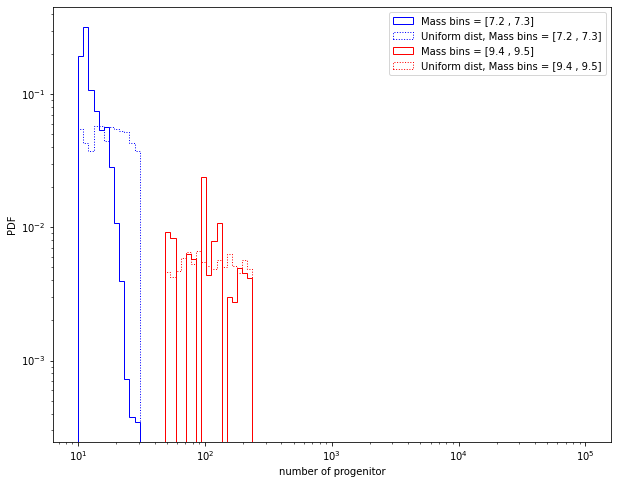

In [5]:
mass_array = np.logspace(7,12,50)

print(np.log10(mass_array))


mass_edged_prog = [[7.2,7.3], [9.4,9.5], [10.5,10.6], [11,11.1]]

colors = ['blue', 'red', 'green', 'purple']
#mass_edged_prog = [[7.2,7.5]]

bins_num_prog = np.logspace(1, 5, 100)

plt.figure(figsize=(10,8))
for i in range(len(mass_edged_prog)):
    ind_mass_prog = np.nonzero((galaxy_data_remnant[0,:] < 10**mass_edged_prog[i][1]) &\
                    (galaxy_data_remnant[0,:] >= 10**mass_edged_prog[i][0]))[0]
    
    print(ind_mass_prog)
    if ind_mass_prog.size > 1:
    
        plt.hist(num_prog[ind_mass_prog],bins = bins_num_prog, density = True,
            label = 'Mass bins = ['+str(mass_edged_prog[i][0])+\
             ' , '+str(mass_edged_prog[i][1])+']', histtype = 'step',
            color = colors[i])
    
    
        sample_uniform = np.random.uniform(min(num_prog[ind_mass_prog]),
                                      max(num_prog[ind_mass_prog]),
                                      1000)
        plt.hist(sample_uniform, bins = bins_num_prog, density = True,
             linestyle = ':',
            label = 'Uniform dist, Mass bins = ['+str(mass_edged_prog[i][0])+\
             ' , '+str(mass_edged_prog[i][1])+']', histtype = 'step',
            color = colors[i])
    
        """
        mean_prog = np.mean(num_prog[ind_mass_prog])
        std_prog = np.std(num_prog[ind_mass_prog])
        sample_norm = np.random.normal(mean_prog, std_prog, 10000)
    
        plt.hist(sample_norm,bins = bins_num_prog, density = True,
             linestyle = ':',
            label = 'Normal Mass bins = ['+str(mass_edged_prog[i][0])+\
             ' , '+str(mass_edged_prog[i][1])+']', histtype = 'step')
        """
    else:
        continue 
plt.ylabel('PDF')
plt.xlabel('number of progenitor')
plt.xscale('log')
plt.yscale('log')

plt.legend()

plt.savefig('distribution_of_progenitors_vs_mass.pdf', format = 'pdf')
plt.show()

In [6]:
# here I am defining the binning of the distribution of progenitor galaxy per SFR and per mass

mass_gal_min = 7

num_bins_form = 80
num_bins_host = num_bins_form+1
Mass_gal_bins_form = np.logspace(mass_gal_min, 12, num_bins_form)
print('formation mass bins = \n', Mass_gal_bins_form)
Mass_gal_bins_host = np.logspace(mass_gal_min, 12, num_bins_host)

Mass_gal_mid_form = Mass_gal_bins_form[0:len(Mass_gal_bins_form)-1]+\
(Mass_gal_bins_form[1:len(Mass_gal_bins_form)]-\
 Mass_gal_bins_form[0:len(Mass_gal_bins_form)-1])/2

Mass_gal_mid_host = Mass_gal_bins_host[0:len(Mass_gal_bins_host)-1]+\
(Mass_gal_bins_host[1:len(Mass_gal_bins_host)]-\
 Mass_gal_bins_host[0:len(Mass_gal_bins_host)-1])/2

num_bins_sfr_form = 50
num_bins_sfr_host = num_bins_sfr_form+1
sfr_gal_bins_form = np.logspace(-4,3,num_bins_sfr_form)
sfr_gal_bins_host = np.logspace(-4,3,num_bins_sfr_host)

# I should save at the end Prob in a numpy file 

sfr_gal_bins_form_mid =  sfr_gal_bins_form[0:len(sfr_gal_bins_form)-1]+\
                            (sfr_gal_bins_form[1:len(sfr_gal_bins_form)]-\
                            sfr_gal_bins_form[0:len(sfr_gal_bins_form)-1])/2

sfr_gal_bins_host_mid = sfr_gal_bins_host[0:len(sfr_gal_bins_host)-1]+\
                        (sfr_gal_bins_host[1:len(sfr_gal_bins_host)]-\
                        sfr_gal_bins_host[0:len(sfr_gal_bins_host)-1])/2

"""
prog_perc_min = 

prog_perc = np.arange(prog_perc_min, prog_perc_max, N_prog_perc)

Prob_perc = np.zeros()
"""

formation mass bins = 
 [1.00000000e+07 1.15688753e+07 1.33838875e+07 1.54836526e+07
 1.79128445e+07 2.07231465e+07 2.39743497e+07 2.77356261e+07
 3.20870000e+07 3.71210501e+07 4.29448799e+07 4.96823959e+07
 5.74769442e+07 6.64943600e+07 7.69264957e+07 8.89953035e+07
 1.02957557e+08 1.19110313e+08 1.37797236e+08 1.59415904e+08
 1.84426271e+08 2.13360453e+08 2.46834047e+08 2.85559230e+08
 3.30359912e+08 3.82189262e+08 4.42149991e+08 5.11517810e+08
 5.91768575e+08 6.84609684e+08 7.92016405e+08 9.16273901e+08
 1.06002585e+09 1.22633068e+09 1.41872667e+09 1.64130720e+09
 1.89880782e+09 2.19670709e+09 2.54134304e+09 2.94004806e+09
 3.40130494e+09 3.93492726e+09 4.55226828e+09 5.26646239e+09
 6.09270466e+09 7.04857404e+09 8.15440740e+09 9.43373222e+09
 1.09137671e+10 1.26260011e+10 1.46068632e+10 1.68984979e+10
 1.95496614e+10 2.26167595e+10 2.61650470e+10 3.02700165e+10
 3.50190046e+10 4.05130497e+10 4.68690419e+10 5.42222101e+10
 6.27289986e+10 7.25703961e+10 8.39557862e+10 9.71274020e+10


'\nprog_perc_min = \n\nprog_perc = np.arange(prog_perc_min, prog_perc_max, N_prog_perc)\n\nProb_perc = np.zeros()\n'

[0, 6.510364294052124, 7.56209135055542, 8.531245708465576, 9.490454196929932, 12.562672138214111, 17.566165924072266, 22.56965970993042]
[1 1 1 1 1 1 1]
[ 5.97116232  7.04956627  8.07461643  8.98787498  9.99303341 15.13231087
 20.00002098]


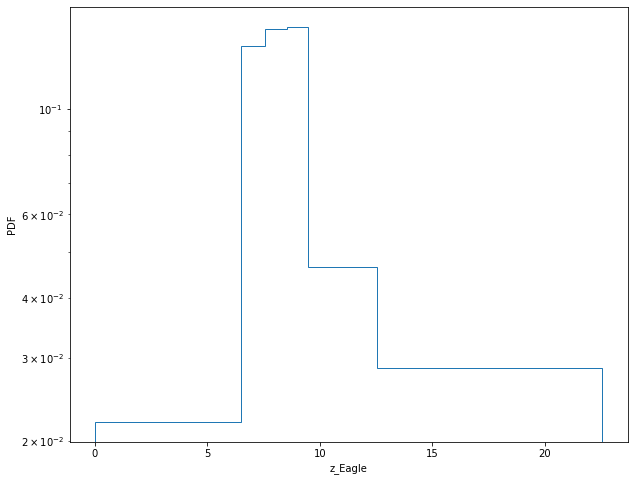

In [7]:
z_Eagle_bins = [0]
for i in range(len(z_Eagle)-1):
    z_Eagle_bins.append(z_Eagle[i]+(z_Eagle[i+1]-z_Eagle[i])/2)
z_Eagle_bins.append(z_Eagle[i+1]+(z_Eagle[i]-z_Eagle[i-1])/2)

print(z_Eagle_bins)

Prob_z = np.histogram(z_Eagle, z_Eagle_bins, density = True)[0]

print(np.histogram(z_Eagle, z_Eagle_bins)[0])

print(z_Eagle)

plt.figure(figsize=(10,8))
plt.hist(z_Eagle,z_Eagle_bins, density = True, histtype = 'step')
plt.yscale('log')
plt.ylabel('PDF')
plt.xlabel('z_Eagle')
plt.show()


formation mass bins = 
 [1.00000000e+07 1.15688753e+07 1.33838875e+07 1.54836526e+07
 1.79128445e+07 2.07231465e+07 2.39743497e+07 2.77356261e+07
 3.20870000e+07 3.71210501e+07 4.29448799e+07 4.96823959e+07
 5.74769442e+07 6.64943600e+07 7.69264957e+07 8.89953035e+07
 1.02957557e+08 1.19110313e+08 1.37797236e+08 1.59415904e+08
 1.84426271e+08 2.13360453e+08 2.46834047e+08 2.85559230e+08
 3.30359912e+08 3.82189262e+08 4.42149991e+08 5.11517810e+08
 5.91768575e+08 6.84609684e+08 7.92016405e+08 9.16273901e+08
 1.06002585e+09 1.22633068e+09 1.41872667e+09 1.64130720e+09
 1.89880782e+09 2.19670709e+09 2.54134304e+09 2.94004806e+09
 3.40130494e+09 3.93492726e+09 4.55226828e+09 5.26646239e+09
 6.09270466e+09 7.04857404e+09 8.15440740e+09 9.43373222e+09
 1.09137671e+10 1.26260011e+10 1.46068632e+10 1.68984979e+10
 1.95496614e+10 2.26167595e+10 2.61650470e+10 3.02700165e+10
 3.50190046e+10 4.05130497e+10 4.68690419e+10 5.42222101e+10
 6.27289986e+10 7.25703961e+10 8.39557862e+10 9.71274020e+10


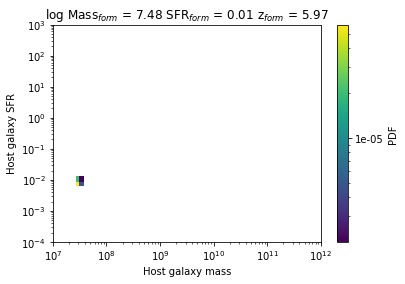

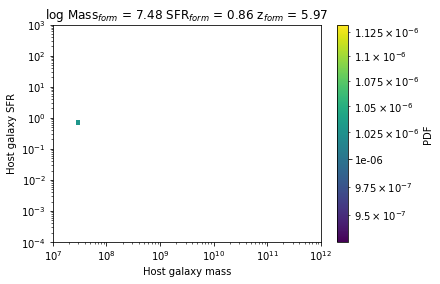

No galaxy found with this properties: log(Mass$_{form}$) = 7.48 SFR$_{form}$ = 8.6 z$_{form}$ = 5.97
No galaxy found with this properties: log(Mass$_{form}$) = 8.49 SFR$_{form}$ = 0.01 z$_{form}$ = 5.97


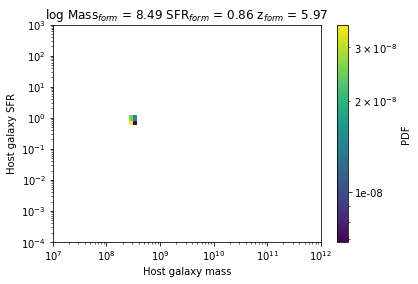

No galaxy found with this properties: log(Mass$_{form}$) = 8.49 SFR$_{form}$ = 8.6 z$_{form}$ = 5.97
No galaxy found with this properties: log(Mass$_{form}$) = 10.01 SFR$_{form}$ = 0.01 z$_{form}$ = 5.97
No galaxy found with this properties: log(Mass$_{form}$) = 10.01 SFR$_{form}$ = 0.86 z$_{form}$ = 5.97
No galaxy found with this properties: log(Mass$_{form}$) = 10.01 SFR$_{form}$ = 8.6 z$_{form}$ = 5.97


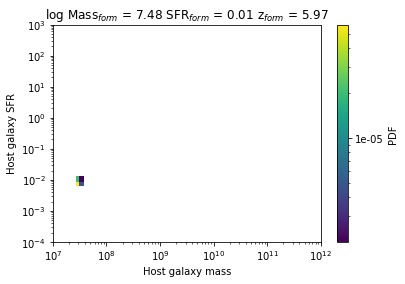

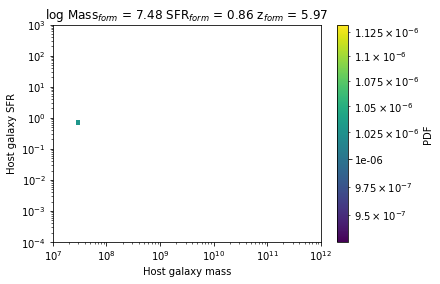

No galaxy found with this properties: log(Mass$_{form}$) = 7.48 SFR$_{form}$ = 8.6 z$_{form}$ = 5.97
No galaxy found with this properties: log(Mass$_{form}$) = 8.49 SFR$_{form}$ = 0.01 z$_{form}$ = 5.97


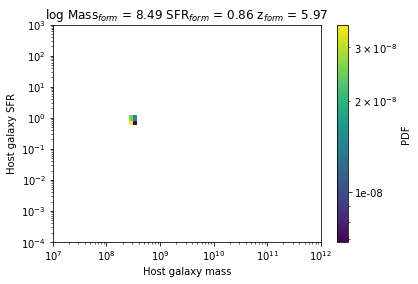

No galaxy found with this properties: log(Mass$_{form}$) = 8.49 SFR$_{form}$ = 8.6 z$_{form}$ = 5.97
No galaxy found with this properties: log(Mass$_{form}$) = 10.01 SFR$_{form}$ = 0.01 z$_{form}$ = 5.97
No galaxy found with this properties: log(Mass$_{form}$) = 10.01 SFR$_{form}$ = 0.86 z$_{form}$ = 5.97
No galaxy found with this properties: log(Mass$_{form}$) = 10.01 SFR$_{form}$ = 8.6 z$_{form}$ = 5.97


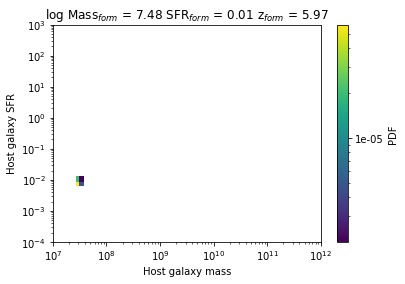

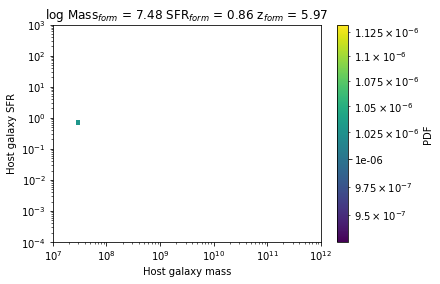

No galaxy found with this properties: log(Mass$_{form}$) = 7.48 SFR$_{form}$ = 8.6 z$_{form}$ = 5.97
No galaxy found with this properties: log(Mass$_{form}$) = 8.49 SFR$_{form}$ = 0.01 z$_{form}$ = 5.97


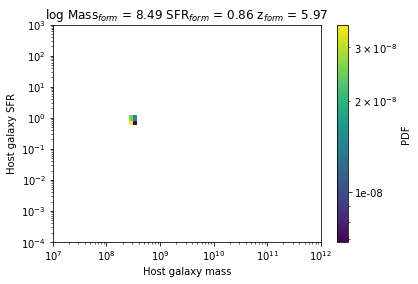

No galaxy found with this properties: log(Mass$_{form}$) = 8.49 SFR$_{form}$ = 8.6 z$_{form}$ = 5.97
No galaxy found with this properties: log(Mass$_{form}$) = 10.01 SFR$_{form}$ = 0.01 z$_{form}$ = 5.97
No galaxy found with this properties: log(Mass$_{form}$) = 10.01 SFR$_{form}$ = 0.86 z$_{form}$ = 5.97
No galaxy found with this properties: log(Mass$_{form}$) = 10.01 SFR$_{form}$ = 8.6 z$_{form}$ = 5.97


In [8]:
num_bins_form = 80
num_bins_host = num_bins_form+1
Mass_gal_bins_form = np.logspace(mass_gal_min, 12, num_bins_form)
print('formation mass bins = \n', Mass_gal_bins_form)
Mass_gal_bins_host = np.logspace(mass_gal_min, 12, num_bins_host)

Mass_gal_mid_form = Mass_gal_bins_form[0:len(Mass_gal_bins_form)-1]+\
(Mass_gal_bins_form[1:len(Mass_gal_bins_form)]-\
 Mass_gal_bins_form[0:len(Mass_gal_bins_form)-1])/2

Mass_gal_mid_host = Mass_gal_bins_host[0:len(Mass_gal_bins_host)-1]+\
(Mass_gal_bins_host[1:len(Mass_gal_bins_host)]-\
 Mass_gal_bins_host[0:len(Mass_gal_bins_host)-1])/2

num_bins_sfr_form = 50
num_bins_sfr_host = num_bins_sfr_form+1
sfr_gal_bins_form = np.logspace(-4,3,num_bins_sfr_form)
sfr_gal_bins_host = np.logspace(-4,3,num_bins_sfr_host)

# I should save at the end Prob in a numpy file 

sfr_gal_bins_form_mid =  sfr_gal_bins_form[0:len(sfr_gal_bins_form)-1]+\
                            (sfr_gal_bins_form[1:len(sfr_gal_bins_form)]-\
                            sfr_gal_bins_form[0:len(sfr_gal_bins_form)-1])/2

sfr_gal_bins_host_mid = sfr_gal_bins_host[0:len(sfr_gal_bins_host)-1]+\
                        (sfr_gal_bins_host[1:len(sfr_gal_bins_host)]-\
                        sfr_gal_bins_host[0:len(sfr_gal_bins_host)-1])/2

z_form_plot = [0,2,4]
mass_form_plot = [10**(7.5),10**(8.5), 1e10]
sfr_form_plot = [1e-2,1e0,1e1]

z_Eagle_ind = np.zeros(len(z_form_plot), dtype = int)
mass_form_ind = np.zeros(len(mass_form_plot), dtype = int)
sfr_form_ind = np.zeros(len(mass_form_plot), dtype = int)
for t in range(len(z_form_plot)):
    z_Eagle_ind[t] = int(np.argmin(abs(z_Eagle-z_form_plot[t])))
    mass_form_ind[t] = int(np.argmin(abs(Mass_gal_mid_form-mass_form_plot[t])))
    sfr_form_ind[t] = int(np.argmin(abs(sfr_gal_bins_form_mid-sfr_form_plot[t])))
     
print(z_Eagle_ind, mass_form_ind, sfr_form_ind)
for y in range(len(z_Eagle_ind)):
    for i in range(len(mass_form_ind)):
        for k in range(len(sfr_form_ind)):
            #plt.contour(Mass_gal_mid_host,sfr_gal_bins_host_mid, np.transpose(Prob[:,:,
            #        mass_form_ind[i], sfr_form_ind[k],z_Eagle_ind[y]]), levels = 10
                       
            #           )
            
            ind_mass_and_z = np.nonzero((galaxy_data_progenitor[2,:] == z_Eagle[z_Eagle_ind[y]]) & \
             (galaxy_data_progenitor[0,:] <= Mass_gal_bins_form[mass_form_ind[i]+1]) & \
             (galaxy_data_progenitor[0,:] > Mass_gal_bins_form[mass_form_ind[i]]) & \
             (galaxy_data_progenitor[1,:] <= sfr_gal_bins_form[sfr_form_ind[k]+1]) & \
             (galaxy_data_progenitor[1,:] > sfr_gal_bins_form[sfr_form_ind[k]]))[0]
            
            if len(ind_mass_and_z) == 0:
                print('No galaxy found with this properties: log(Mass$_{form}$) = '+ \
                         str(round(np.log10(
                            Mass_gal_mid_form[mass_form_ind[i]]),2))+ \
                    ' SFR$_{form}$ = '+str(round(sfr_gal_bins_form_mid[sfr_form_ind[k]],2))+ \
                 ' z$_{form}$ = '+str(round(z_Eagle[z_Eagle_ind[y]],2)))
            else:
                plt.figure(figsize=(6,4))
                selected_IDs = np.unique(galaxy_data_progenitor[3,ind_mass_and_z])
                # This should be a bit faster
                ind_ID = np.zeros(len(selected_IDs), dtype = int)
                for d in range(len(selected_IDs)):
                    ind_ID[d] = np.nonzero(galaxy_data_remnant[3,:] == selected_IDs[d])[0]
                host_galaxies_mass = galaxy_data_remnant[0,ind_ID]
                host_galaxies_sfr = galaxy_data_remnant[1,ind_ID]
                plt.hist2d(host_galaxies_mass,host_galaxies_sfr, 
                               bins = [Mass_gal_bins_host,sfr_gal_bins_host],
                               density = True, norm=mpl.colors.LogNorm(), 
                           cmap=cm.viridis)
                plt.title('log Mass$_{form}$ = '+ \
             str(round(np.log10(
                 Mass_gal_mid_form[mass_form_ind[i]]),2))+ \
                 ' SFR$_{form}$ = '+str(round(sfr_gal_bins_form_mid[sfr_form_ind[k]],2))+ \
                 ' z$_{form}$ = '+str(round(z_Eagle[z_Eagle_ind[y]],2)))
                        #,xy = (0.2,0.8),
                        #xycoords = 'axes fraction'
                        #)
                plt.xlabel('Host galaxy mass')
                plt.ylabel('Host galaxy SFR')
                #plt.title(r'$\mathcal{P}(M_{\rm{host}},SFR_{\rm{host}}| M_{\rm{form}},SFR_{\rm{form}},z_{\rm{host}})$')
                plt.xscale('log')
                plt.yscale('log')
                formatter = LogFormatter(10, labelOnlyBase=False) 
                plt.colorbar(label="PDF", format=formatter)
                
                plt.savefig('probability_plots/cond_prob_logM_form_'+ \
             str(round(np.log10(
                 Mass_gal_mid_form[mass_form_ind[i]]),2))+ \
                 '_SFR_form_'+str(round(sfr_gal_bins_form_mid[sfr_form_ind[k]],2))+ \
                 '_z_form_'+str(round(z_Eagle[z_Eagle_ind[y]],2))+'.pdf', format = 'pdf')
                plt.show()

In [9]:
# The probablity depends just on the merger tree,
# It can be evaluated just once!


                # host galaxy               # host SFR
Prob = np.zeros((len(Mass_gal_bins_host)-1,len(sfr_gal_bins_host)-1,
                 
                # form galaxy             # SFR form             # formation redshift
                len(Mass_gal_bins_form)-1,len(sfr_gal_bins_form)-1,len(z_Eagle)))

"""                         # form galaxy      # formation redshift
Mean_host_mass = np.zeros((len(Mass_gal_bins_form)-1,len(z_Eagle)))
                           # form galaxy      # formation redshift
q75_host_mass = np.zeros((len(Mass_gal_bins_form)-1,len(z_Eagle)))
                            # form galaxy      # formation redshift
q25_host_mass = np.zeros((len(Mass_gal_bins_form)-1,len(z_Eagle)))
Prob_form = np.zeros((len(Mass_gal_bins_form)-1,len(z_Eagle))) """
i = 0
for i in range(len(z_Eagle)):
        print('formation redshift = ', z_Eagle[i])
        """ print('formation redshift = ', z_Eagle[i])
        ind_only_z = galaxy_data_progenitor[2,:] == z_Eagle[i]
         this is the probability distribution of mass formed at redshift z_i
        Prob_form[:,i] = np.nan_to_num(np.histogram(galaxy_data_progenitor[0,ind_only_z],
                            Mass_gal_bins_form, density = True)[0]) """
        for y in tqdm(range(len(Mass_gal_bins_form)-1)):
            #print('    formation mass = ', np.log10(Mass_gal_bins_form[y]))
            for z in range(len(sfr_gal_bins_form)-1):
                # here I select all progenitors galaxies that fulfill the conditions 
                # in terms of formation mass and star formation
                ind_mass_and_z = np.nonzero((galaxy_data_progenitor[2,:] == z_Eagle[i]) & \
                            (galaxy_data_progenitor[0,:] <= Mass_gal_bins_form[y+1]) & \
                            (galaxy_data_progenitor[0,:] > Mass_gal_bins_form[y]) & \
                            (galaxy_data_progenitor[1,:] <= sfr_gal_bins_form[z+1]) & \
                            (galaxy_data_progenitor[1,:] > sfr_gal_bins_form[z]))[0]
                #print(ind_mass_and_z)
                if len(ind_mass_and_z) == 0:
                    #print('no elements available')
                    Prob[:,:,y,z,i] = 0
                else:
                    selected_IDs = np.unique(galaxy_data_progenitor[3,ind_mass_and_z])
                    # This should be a bit faster
                    ind_ID = np.zeros(len(selected_IDs), dtype = int)
                    for d in range(len(selected_IDs)):
                        ind_ID[d] = np.nonzero(galaxy_data_remnant[3,:] == selected_IDs[d])[0]
                
                    host_galaxies_mass = galaxy_data_remnant[0,ind_ID]
                    host_galaxies_sfr = galaxy_data_remnant[1,ind_ID]
        
                    pdf_values = np.nan_to_num(
                        np.histogram2d(host_galaxies_mass,host_galaxies_sfr, 
                               bins = [Mass_gal_bins_host,sfr_gal_bins_host],
                               density = True)[0])
                    Prob[:,:,y,z,i] = pdf_values


  0%|          | 0/79 [00:00<?, ?it/s]

formation redshift =  5.97116231918335


  0%|          | 0/79 [00:00<?, ?it/s]

formation redshift =  7.049566268920898


  0%|          | 0/79 [00:00<?, ?it/s]

formation redshift =  8.074616432189941


  0%|          | 0/79 [00:00<?, ?it/s]

formation redshift =  8.987874984741211


  0%|          | 0/79 [00:00<?, ?it/s]

formation redshift =  9.993033409118652


  1%|▏         | 1/79 [00:00<00:15,  5.12it/s]

formation redshift =  15.13231086730957


  1%|▏         | 1/79 [00:00<00:14,  5.39it/s]

formation redshift =  20.00002098083496


100%|██████████| 79/79 [00:13<00:00,  5.95it/s]


In [10]:
# I should save at the end Prob in a numpy file 
destination_out = cosmo_sim+'_catalogs/probability/'
np.savez(destination_out+'/Prob_'+cosmo_sim+'-MergerTrees_Ms'+gal_mass_min+'-'+gal_mass_max+\
                   '_SFR'+sfr_min+'-'+sfr_max+'_N'+N_Eagle+'_'+snapshot,Prob)